In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [3]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [4]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [5]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print("vocab size: ", vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size:  65


In [6]:
stoi = {char: i for i, char in enumerate(chars)}
itos = {i: char for i, char in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s] # takes a string, returns list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # takes list of integers, returns a string

In [7]:
print(encode("i am navdeep"))
print(decode([47, 1, 39, 51, 1, 52, 39, 60, 42, 43, 43, 54]))
assert decode(encode("i am navdeep")) == "i am navdeep"

[47, 1, 39, 51, 1, 52, 39, 60, 42, 43, 43, 54]
i am navdeep


In [8]:
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape)

torch.Size([1115394])


In [9]:
# split dataset
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [10]:
torch.manual_seed(1337)

batch_size = 4 # independent sequences that will be processed in parallel
block_size = 8 # maximum context length

def get_batch(split):
    """
    returns a batch (x, y) of batch_size = 4 arrays
    arrays are of size block_size = 8
    """
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,)) # get batch_size=4 random numbers from len(data) - block_size. minus block_size is to prevent overflow
    x = torch.stack([data[i:i+block_size] for i in ix]) # stack batch_size=4 arrays cotaining block_size=8 elements from data starting from index in ix
    y = torch.stack([data[i+1:i+1+block_size] for i in ix]) # stack batch_size=4 arrays cotaining block_size=8 elements from data starting from index+1 in ix

    return x, y

In [11]:
xb, yb = get_batch("train")
print(xb)
print(yb)

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b][:t+1]
        target = yb[b][t]
        print(f'{context.tolist()} --> {target}')

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
[24] --> 43
[24, 43] --> 58
[24, 43, 58] --> 5
[24, 43, 58, 5] --> 57
[24, 43, 58, 5, 57] --> 1
[24, 43, 58, 5, 57, 1] --> 46
[24, 43, 58, 5, 57, 1, 46] --> 43
[24, 43, 58, 5, 57, 1, 46, 43] --> 39
[44] --> 53
[44, 53] --> 56
[44, 53, 56] --> 1
[44, 53, 56, 1] --> 58
[44, 53, 56, 1, 58] --> 46
[44, 53, 56, 1, 58, 46] --> 39
[44, 53, 56, 1, 58, 46, 39] --> 58
[44, 53, 56, 1, 58, 46, 39, 58] --> 1
[52] --> 58
[52, 58] --> 1
[52, 58, 1] --> 58
[52, 58, 1, 58] --> 46
[52, 58, 1, 58, 46] --> 39
[52, 58, 1, 58, 46, 39] --> 58
[52, 58, 1, 58, 46, 39, 58] --> 1
[52, 58, 1, 58, 46, 39, 58, 1] --> 46
[25] --> 17
[25, 17] --> 27
[25, 17, 27] --> 10
[25, 17, 27, 10]

In [12]:
class BigramLangModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # B, T, C - Batch, Time (one char in a block), Channel (embedding)
        # idx and targets are both (B, T) size inputs

        # logits are predictions/scores of next character and here it is simply the embedding of input
        logits = self.token_embedding_table(idx) # (B, T, C)

        if targets is None:
            loss = None

        else:
            # logits and targets need to be reshaped for cross entropy
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        return logits, loss
    
    def generate(self, idx, max_new_tokens):
        # max_new_tokens - number of characters to generate
        # idx - (B, T)
        for _ in range(max_new_tokens):
            # this will return the logits for all the tokens in idx
            logits, loss = self.forward(idx) # (B, T, C)
            # take out the logits for only the last token because we'll generate the next char only on the basis of last char
            logits = logits[:, -1, :] # (B, C)
            # get the probs from logits
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the prob distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # concatenate for output
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            # next character will be found out on the basis of last character till the loop runs
        return idx

In [13]:
torch.manual_seed(1337)

m = BigramLangModel(vocab_size)
logits, loss = m(xb, yb)
print(xb.shape, logits.shape, loss)

# generate
idx=torch.zeros((1, 1), dtype=torch.long) # this is acting as the starting character -> tensor([[0]])
print(decode(m.generate(idx, max_new_tokens=100)[0].tolist()))

torch.Size([4, 8]) torch.Size([32, 65]) tensor(4.8786, grad_fn=<NllLossBackward0>)

SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


### token_embedding_table
- The token_embedding_table is of size (65, 65). For each char in vocab, the table will return an array of 65 integers.
- These integers will work as the probability of being the next character. This is why the 2nd dimension of the table is of size 65.

### cross_entropy
- Cross Entropy expects the logits of 2 dimensions and target to be of 1 dimension. That's why, the logits and targets are being reshaped.
- Logits are converted into (BxT, C) and Targets are converted into (BxT).
- In the example output above dimensions of logits is (32, 65) and of targets is (32).
- Cross entropy will take the first row of logits (logits[0, :]) which contains 65 integers and take the first integer from target   (target[0]) and check the probability at "targetth" element, i.e. logits[0, target[0]]

In [14]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [15]:
batch_size = 32
for steps in range(1000):
    xb, yb = get_batch('train')
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

3.704137086868286


In [16]:
print(decode(m.generate(idx=torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


Wh;;Sq.f ustNzknc
kwgOj$dhPWr,SV?hsusiKpgXXUh;Apmem d?hESXI.i;TrJgkiF-oKbXCAA -botrngFCHAUQkn$

pn$w-gHoi?wtd!
LLULIfSK'bAw :M.ZtOptXEQcL?hfaofqbPd?OnonQQJMap$aypupIBYGUsZaI'ottllo..k$W$Akp?yl?ajKlzY!lx&QQLW? t,bXFkyhl-dmVsHeckhRl,jSClgjuk:3Iv
?OqlrV;!Plxfzgy;;
'mRjuBQ&xk!$
h
SiruDJgKuDny,S$ERf.?GSV-ivvKcOvi-nQGX&q-YQbm dEM?px;Akr-IESq--wIWId
RFgXTpDUgM:CK$I!uo'IBT -
j?wfy fFr.&fiqtRS.ZttxGh' a!ogrn$zoZqbocL&yIffBDWNUboscuQqo.Fls,?,M?eZxHx?p?EV.mJiHqHnxT  bQpa;P fawiF$-QbWv&f:CVDCBfano,b?$Esev.?


# Self Attention

In [17]:
tril = torch.tril(torch.ones((8, 8)))
wei = torch.zeros((8, 8))
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim=-1) # exponentiate and divide by sum
wei

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

In [18]:
x = torch.randn((8, 2))
print(x)
xbow = wei@x
xbow

tensor([[ 0.3055,  1.3811],
        [ 0.3784, -0.5543],
        [-0.8759,  0.0246],
        [-0.2748, -0.1904],
        [-0.7005, -0.7848],
        [ 0.2045,  1.3828],
        [-1.8769, -2.3060],
        [-0.5329,  0.0075]])


tensor([[ 0.3055,  1.3811],
        [ 0.3419,  0.4134],
        [-0.0640,  0.2838],
        [-0.1167,  0.1653],
        [-0.2335, -0.0247],
        [-0.1605,  0.2098],
        [-0.4057, -0.1496],
        [-0.4216, -0.1299]])

- Every row in xbow is average of itself and all previous rows.
- You can do weighted aggregation of tokens from past using matrix multiplication of lower triangular fashion.
- The elements in the lower triangular part of wei matrix tells how much part of token is taken while aggregation.

In [ ]:
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B, T, C)

# single Head of self attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)   # (C, 16)
query = nn.Linear(C, head_size, bias=False) # (C, 16)
value = nn.Linear(C, head_size, bias=False) # (C, 16)

k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
v = value(x) # (B, T, 16)


# following is the dot product between query and key vectors of each token
# dot product gives the similarity between query and key
wei = q @ k.transpose(-2, -1)  # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

wei = wei * head_size**(-0.5) # scaling

tril = torch.tril(torch.ones(T, T))
# wei = torch.zeros((T, T))
wei = wei.masked_fill(tril == 0, float('-inf'))

wei = F.softmax(wei, dim=-1) # (B, T, T)
# out = wei @ x # (B, T, C)
out = wei @ v # (B, T, T) @ (B, T, 16) ---> (B, T, 16)
out.shape

tensor([[-1.7629, -1.3011,  0.5652,  2.1616, -1.0674,  1.9632,  1.0765, -0.4530],
        [-3.3334, -1.6556,  0.1040,  3.3782, -2.1825,  1.0415, -0.0557,  0.2927],
        [-1.0226, -1.2606,  0.0762, -0.3813, -0.9843, -1.4303,  0.0749, -0.9547],
        [ 0.7836, -0.8014, -0.3368, -0.8496, -0.5602, -1.1701, -1.2927, -1.0260],
        [-1.2566,  0.0187, -0.7880, -1.3204,  2.0363,  0.8638,  0.3719,  0.9258],
        [-0.3126,  2.4152, -0.1106, -0.9931,  3.3449, -2.5229,  1.4187,  1.2196],
        [ 1.0876,  1.9652, -0.2621, -0.3158,  0.6091,  1.2616, -0.5484,  0.8048],
        [-1.8044, -0.4126, -0.8306,  0.5898, -0.7987, -0.5856,  0.6433,  0.6303]],
       grad_fn=<SelectBackward0>)
tensor([[-0.4407, -0.3253,  0.1413,  0.5404, -0.2668,  0.4908,  0.2691, -0.1132],
        [-0.8334, -0.4139,  0.0260,  0.8446, -0.5456,  0.2604, -0.0139,  0.0732],
        [-0.2557, -0.3152,  0.0191, -0.0953, -0.2461, -0.3576,  0.0187, -0.2387],
        [ 0.1959, -0.2004, -0.0842, -0.2124, -0.1401, -0.2925, 

torch.Size([4, 8, 16])

- Query: "What I'm looking for"
- Key: "What I can provide"
- Value: "If you're interested in me, here's what I will communicate to you"
- Q @ K.T: Attention Scores
    - Provides the similarity between the Q and K vectors. This is done by doing the dot product of Q and K matrices. Dot product provides the similarity between two vectors.
    - Transpose is done to match the dimensions of the metrices so that they can be multiplied.
    - Output is a scaler number specifying the similarity or alignment between the tokens. When two vectors (like the query and key vectors) are aligned, their dot product is high, indicating a strong similarity. If they’re orthogonal or pointing in different directions, the dot product is low or zero, indicating little to no similarity.
- Masking: Masking is done so that a token only gets to look itself and previous tokens only, not the future tokens. In general, it controls what each token is allowed to attend to.
- Softmax: Converts the numbers to probabilities.
- out = wei @ V: Context Aware Tokens.
    - Each self attention head captures different aspects of the input. For example, one head might focus on syntactic relationships, while another might capture semantic relationships. That's why we've a separate V (value) matrix instead of applying operations on original X matrix. It allows each head to learn varied relationships in data.
    - Originally each token's embeddings in X contain an isolated piece of information, only about itself.
    - On multiplying the wei matrix with V (which is derived from X), each token's representation in out matrix contains mix of informations from other relevant tokens.
    - It's weighted combination of wei and V matrices. Tokens that were considered highly relevant to the token in question contribute more to its new embedding, while less relevant tokens contribute less. 

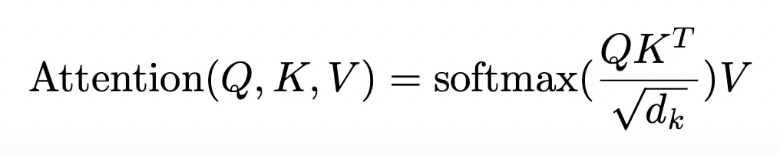

#### Attention Notes

- Attention is a **communication mechanism**. It can be seen as nodes in directed graph looking a each other and aggregating information via weighted sum from all the nodes that point to them.
    - In our case, the graph contains 8 nodes (block_size), where each node is pointing to itself and all the previous nodes are pointing to it.
    - But in principal attention can be applied to any arbitrary directed graph and it is just a communication mechanism between the node.
    - In many cases all the nodes talk to each other fully (e.g. while doing sentiment analysis). In that case just delete the masking code. This means it is an **encoder** block.
    - What we have built is a **decoder** block where the nodes don't talk to future nodes.
- The mechanism which we've built here is **self attention**, where all the K, Q and V matrices are based on X. X is the source of K, Q and V. But in case of **cross attention** the source for K, Q and V is different. 
- Currently there's no notion of space. The nodes don't have any idea where they're positioned in the graph. That's why also need to encode them positionally.
- Each example across batch dimension never talk to each other. There are 8 nodes/tokens in all the 4 batches. Only the nodes in a batch talk to each other.
- "Scaled" attention additionally divides wei by 1/sqrt(head_size). This makes it so when input Q, K are unit variance, `wei` will be unit variance too and Softmax will stay diffuse and not saturate too much. *Illustrated Below.*
    - If `wei` takes very high positive or negative numbers, then applying softmax will make it similar to one-hot encoding. Softmax will sharpen towards whatever number is highest. It will be way too peaky and nodes will aggregate information from a single node. This is undesirable, especially at initialization. Hence scaling is used to control the variance at initialization.


In [ ]:
zz= torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]) # values very close to zero
print(zz.var())
print(torch.softmax(zz, dim=-1))

yy= torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*100 # high values
print(yy.var()) # very high variance
print(torch.softmax(yy, dim=-1)) # output is like one-hot encoding. Peaky.

tensor(0.0950)
tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])
tensor(950.)
tensor([4.2484e-18, 3.9754e-31, 2.0612e-09, 3.9754e-31, 1.0000e+00])


### Multi-Head Attention

- Complete input is processed by multiple independent attention heads. Each head performs self-attention over the input but operates in a subspace of the total embedding dimension i.e. reduced dimensionality (n_embd//4).
- The outputs of these heads are then concatenated along the last dimension, effectively combining the learned representations from each head. The final output size after concatenation is same as when there's only single head.
- The split in `n_embd` forces each head to focus on a smaller, specialized subspace, leading to richer and more diverse representations. Single-head attention, in contrast, tries to do everything in one step and lacks the ability to represent this diversity.
- Imagine you’re analyzing an image:
    - Single Attention Head: Processes the entire image in a single pass and captures all relationships but might dilute fine-grained details.
    - Multi-Head Attention: Each head looks at the image but focuses on different patterns: edges, colors, shapes, etc. When combined, you get a more complete understanding of the image.

#### Feed Forward

- After multi head attention, the input is passed through linear transformation and non-linearity.
- Self-attention only combines token embeddings in a linear way. This limits the model's ability to detect complex patterns, like hierarchical relationships or fine-grained distinctions.
- The non-linear ReLU activation allows the model to learn interactions between features that wouldn't be captured linearly.
- The feed-forward layer ensures that after self-attention:
    - Each token's embedding is richer and more refined.
    - The model gains more capacity to learn complex patterns.
- This is on per token level. All the tokens do this independently. So, self-attention is communication and once they have gatthered all the data, they need think on that data individually.

**Analogy**

Think of a project team where:
- Self-Attention (Communication): Everyone shares information with each other about their roles and responsibilities.
- FeedForward Layer (Computation): After sharing, each person processes that information individually to focus on their specific tasks.
Without the second step, the team might lack depth in individual contributions.

#### Blocks

- The Block class represents a fundamental building block of the Transformer architecture. It combines two key components of a Transformer layer: Communication: Self-Attention (MultiHeadAttention), Computation: FeedForward.
- Multiple Block layers are stacked sequentially. Each Block layer builds upon the output of the previous one, progressively refining the token embeddings.
- The combination of multiple Blocks allows the model to handle complex patterns, such as understanding the meaning of ambiguous words based on distant tokens.


#### Residual/Skip Connections

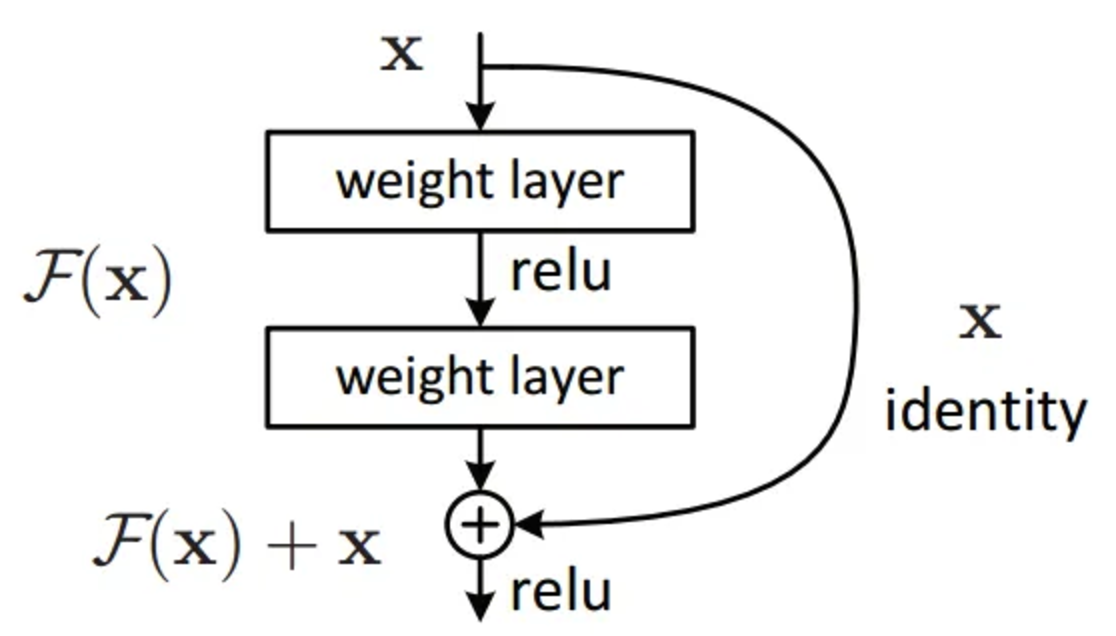

- A residual connection (also known as a skip connection) is a shortcut that allows the input to a layer to bypass certain operations and be added directly to the output of that layer.
- output=Layer(x)+x
- In very deep networks, gradients can become extremely small during backpropagation, making it difficult for the model to learn. Residual connections provide a direct path for gradients to flow through, helping to preserve the gradients and maintain effective learning, even in deep architectures.
- As we saw in previously that when there's an addition operation, it distributes gradients equally to both of its branches. So, the residual connection helps to preserve gradients during backpropagation, especially in very deep networks. Without residual connections, gradients can vanish as they propagate backward through many layers.